In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# I want to load a csv placed in ../logs/log_ear_mar.csv
# with this header timestamp;path_img;ear;mar

# And load into a dataframe using pandas

file_path = "../logs/log_ear_mar.csv"

df = pd.read_csv(file_path, sep=";")

In [3]:
df['category'] = df['path_img'].apply(lambda x: x.split('/')[2])
df

# cast ear and mar to float
df['ear'] = df['ear'].astype(float)
df['mar'] = df['mar'].astype(float)

# delete rows with ear or mar <= 0
df = df[df['ear'] > 0]
df = df[df['mar'] > 0]

KeyError: 'path_img'

In [132]:
df

,timestamp,path_img,ear,mar,category
0,20230911220029563455,./frames/bostezo/frame_20230911220029563455.jpg,0.140504,0.682872,bostezo
1,20230911220029682586,./frames/bostezo/frame_20230911220029682586.jpg,0.147645,0.800760,bostezo
2,20230911220029743451,./frames/bostezo/frame_20230911220029743451.jpg,0.189989,0.849610,bostezo
3,20230911220029822007,./frames/bostezo/frame_20230911220029822007.jpg,0.132697,0.818756,bostezo
4,20230911220029908184,./frames/bostezo/frame_20230911220029908184.jpg,0.159582,0.852484,bostezo
...,...,...,...,...,...
3840,20230913215051108609,./frames/hablando/frame_20230913215051108609.jpg,0.212483,0.047913,hablando
3841,20230913215051216359,./frames/hablando/frame_20230913215051216359.jpg,0.212483,0.047913,hablando
3842,20230913215051291616,./frames/hablando/frame_20230913215051291616.jpg,0.239528,0.064424,hablando
3843,20230913215051382930,./frames/hablando/frame_20230913215051382930.jpg,0.235802,0.062470,hablando


In [133]:
# mostrar las distintas categorias
category_list = df['category'].unique()

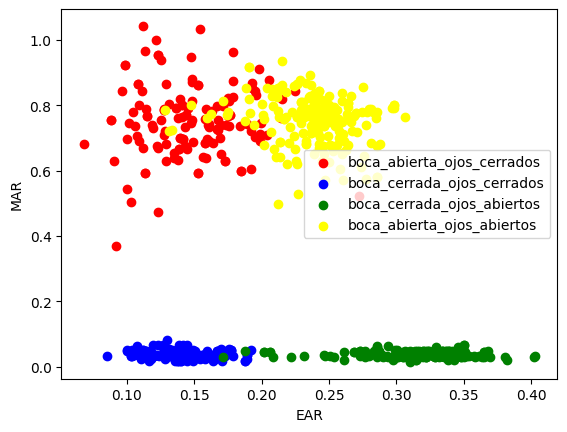

In [134]:
# plot ear vs mar, coloring different categories
colors = {
    'boca_abierta_ojos_cerrados': 'red',
    'boca_cerrada_ojos_cerrados': 'blue',
    'boca_cerrada_ojos_abiertos': 'green',
    'boca_abierta_ojos_abiertos': 'yellow'
}

# Plot a scatter plot with labels per category
for category in colors.keys():
    plt.scatter(df[df['category'] == category]['ear'], df[df['category'] == category]['mar'], c=colors[category], label=category)

plt.xlabel('EAR')
plt.ylabel('MAR')
plt.legend()
plt.show()


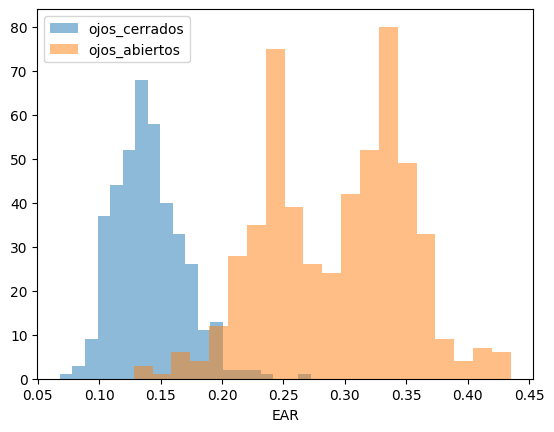

In [135]:
# Create a distribution plot for categories that contains 'ojos_cerrados' vs 'ojos_abiertos' and EAR
plt.hist(df[df['category'].str.contains('ojos_cerrados')]['ear'], bins=20, alpha=0.5, label='ojos_cerrados')
plt.hist(df[df['category'].str.contains('ojos_abiertos')]['ear'], bins=20, alpha=0.5, label='ojos_abiertos')
plt.xlabel('EAR')
plt.legend()
plt.show()

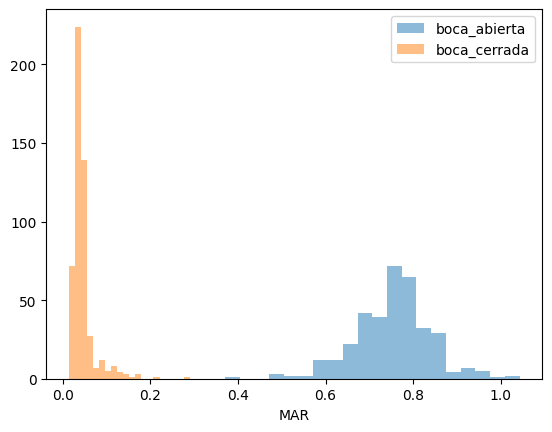

In [136]:
# Create a distribution plot for categories that contains 'boca_abierta' vs 'boca_cerrada' and MAR
plt.hist(df[df['category'].str.contains('boca_abierta')]['mar'], bins=20, alpha=0.5, label='boca_abierta')
plt.hist(df[df['category'].str.contains('boca_cerrada')]['mar'], bins=20, alpha=0.5, label='boca_cerrada')
plt.xlabel('MAR')
plt.legend()
plt.show()

In [139]:
# Filter only the category like "boca_xxx_ojos_xxx"
df_filtered = df[df['category'].str.contains('boca_') & df['category'].str.contains('_ojos_')]

# Calculate the THRESHOLD for EAR and MAR to optimize the classification
# We will use the mean of the "ojos_cerrados" and "ojos_abiertos" categories
# and the mean of the "boca_abierta" and "boca_cerrada" categories
ear_threshold = (df_filtered[df_filtered['category'].str.contains('ojos_cerrados')]['ear'].mean() + df_filtered[df_filtered['category'].str.contains('ojos_abiertos')]['ear'].mean()) / 2
mar_threshold = (df_filtered[df_filtered['category'].str.contains('boca_abierta')]['mar'].mean() + df_filtered[df_filtered['category'].str.contains('boca_cerrada')]['mar'].mean()) / 2

print("EAR threshold: ", ear_threshold)
print("MAR threshold: ", mar_threshold)

# Contando todo
# EAR threshold:  0.21733906173899536
# MAR threshold:  0.3988620258294028

# Filtrando datos
# EAR threshold:  0.20950204295557165
# MAR threshold:  0.39596885286034145

EAR threshold:  0.20950204295557165
MAR threshold:  0.39596885286034145


In [145]:
# Add columns with threshold values and create a new column with the classification
df['ear_threshold'] = ear_threshold
df['mar_threshold'] = mar_threshold

# one or zero for classification
df['ear_classification'] = (df['ear'] > df['ear_threshold']).astype(int)
df['mar_classification'] = (df['mar'] > df['mar_threshold']).astype(int)

FRAMES = 150

# add columns with min and max values for the past 100 frames of each timestamp and for category
df['ear_min'] = df.groupby('category')['ear'].rolling(FRAMES).min().reset_index(0, drop=True)
df['ear_max'] = df.groupby('category')['ear'].rolling(FRAMES).max().reset_index(0, drop=True)
df['mar_min'] = df.groupby('category')['mar'].rolling(FRAMES).min().reset_index(0, drop=True)
df['mar_max'] = df.groupby('category')['mar'].rolling(FRAMES).max().reset_index(0, drop=True)

# add columns with the mean of the past FRAMES seconds of each timestamp and for category
df['ear_mean'] = df.groupby('category')['ear'].rolling(FRAMES).mean().reset_index(0, drop=True)
df['mar_mean'] = df.groupby('category')['mar'].rolling(FRAMES).mean().reset_index(0, drop=True)

# add columns with the std of the past FRAMES seconds of each timestamp and for category
df['ear_std'] = df.groupby('category')['ear'].rolling(FRAMES).std().reset_index(0, drop=True)
df['mar_std'] = df.groupby('category')['mar'].rolling(FRAMES).std().reset_index(0, drop=True)

# add columns with the median of the past FRAMES seconds of each timestamp and for category
df['ear_median'] = df.groupby('category')['ear'].rolling(FRAMES).median().reset_index(0, drop=True)
df['mar_median'] = df.groupby('category')['mar'].rolling(FRAMES).median().reset_index(0, drop=True)

# add columns with the variance of the past FRAMES seconds of each timestamp and for category
df['ear_var'] = df.groupby('category')['ear'].rolling(FRAMES).var().reset_index(0, drop=True)
df['mar_var'] = df.groupby('category')['mar'].rolling(FRAMES).var().reset_index(0, drop=True)

# # add columns with the skew of the past FRAMES seconds of each timestamp and for category
df['ear_skew'] = df.groupby('category')['ear'].rolling(FRAMES).skew().reset_index(0, drop=True)
df['mar_skew'] = df.groupby('category')['mar'].rolling(FRAMES).skew().reset_index(0, drop=True)

# # add columns with the kurt of the past FRAMES seconds of each timestamp and for category
df['ear_kurt'] = df.groupby('category')['ear'].rolling(FRAMES).kurt().reset_index(0, drop=True)
df['mar_kurt'] = df.groupby('category')['mar'].rolling(FRAMES).kurt().reset_index(0, drop=True)

df

,timestamp,path_img,ear,mar,category,ear_threshold,mar_threshold,ear_classification,mar_classification,ear_min,...,ear_std,mar_std,ear_median,mar_median,ear_var,mar_var,ear_skew,mar_skew,ear_kurt,mar_kurt
0,20230911220029563455,./frames/bostezo/frame_20230911220029563455.jpg,0.140504,0.682872,bostezo,0.209502,0.395969,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20230911220029682586,./frames/bostezo/frame_20230911220029682586.jpg,0.147645,0.800760,bostezo,0.209502,0.395969,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20230911220029743451,./frames/bostezo/frame_20230911220029743451.jpg,0.189989,0.849610,bostezo,0.209502,0.395969,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230911220029822007,./frames/bostezo/frame_20230911220029822007.jpg,0.132697,0.818756,bostezo,0.209502,0.395969,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20230911220029908184,./frames/bostezo/frame_20230911220029908184.jpg,0.159582,0.852484,bostezo,0.209502,0.395969,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840,20230913215051108609,./frames/hablando/frame_20230913215051108609.jpg,0.212483,0.047913,hablando,0.209502,0.395969,1,0,0.188403,...,0.067375,0.026304,0.319602,0.044615,0.004539,0.000692,0.282509,2.678162,-0.147774,10.243314
3841,20230913215051216359,./frames/hablando/frame_20230913215051216359.jpg,0.212483,0.047913,hablando,0.209502,0.395969,1,0,0.188403,...,0.068046,0.026304,0.318662,0.044615,0.004630,0.000692,0.278955,2.677346,-0.183260,10.240432
3842,20230913215051291616,./frames/hablando/frame_20230913215051291616.jpg,0.239528,0.064424,hablando,0.209502,0.395969,1,0,0.188403,...,0.068426,0.026340,0.317674,0.044615,0.004682,0.000694,0.290837,2.654744,-0.213535,10.121281
3843,20230913215051382930,./frames/hablando/frame_20230913215051382930.jpg,0.235802,0.062470,hablando,0.209502,0.395969,1,0,0.188403,...,0.068799,0.026367,0.316716,0.044615,0.004733,0.000695,0.305149,2.636447,-0.237424,10.027286


In [146]:
category_list

array(['bostezo', 'ojos_cerrados', 'ojos_abiertos', 'boca_cerrada',
       'hablando', 'bostezando', 'boca_abierta_ojos_cerrados',
       'boca_cerrada_ojos_cerrados', 'boca_cerrada_ojos_abiertos',
       'boca_abierta_ojos_abiertos', 'durmiendome'], dtype=object)

In [142]:
# Plot features vs time for category
def plot_ear(category):
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear'], label='ear')
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_threshold'], label='ear_threshold')
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_mean'], label='ear_mean')
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_min'], label='ear_min')
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_max'], label='ear_max')
    # plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_std'], label='ear_std')
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_median'], label='ear_median')
    # plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_var'], label='ear_var')
    # plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_skew'], label='ear_skew')
    # plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_kurt'], label='ear_kurt')
    plt.xlabel('time')
    plt.legend()
    plt.show()

def plot_mar(category):
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar'], label='mar')
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_threshold'], label='mar_threshold')
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_mean'], label='mar_mean')
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_min'], label='mar_min')
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_max'], label='mar_max')
    # plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_std'], label='mar_std')
    plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_median'], label='mar_median')
    # plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_var'], label='mar_var')
    # plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_skew'], label='mar_skew')
    # plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_kurt'], label='mar_kurt')
    plt.xlabel('time')
    plt.legend()
    plt.show()


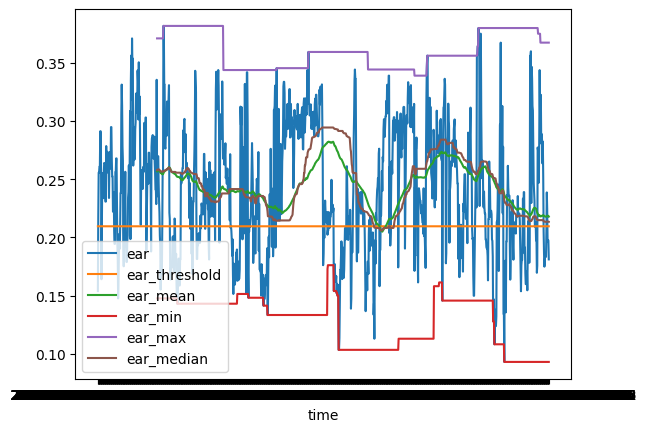

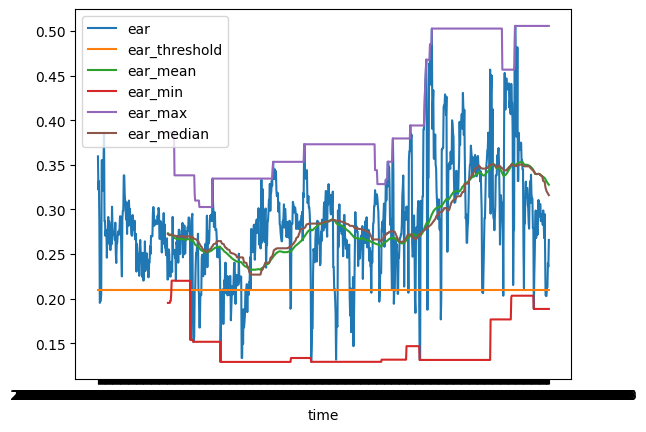

In [147]:
category = "durmiendome"
plot_ear(category)

category = "hablando"
plot_ear(category)

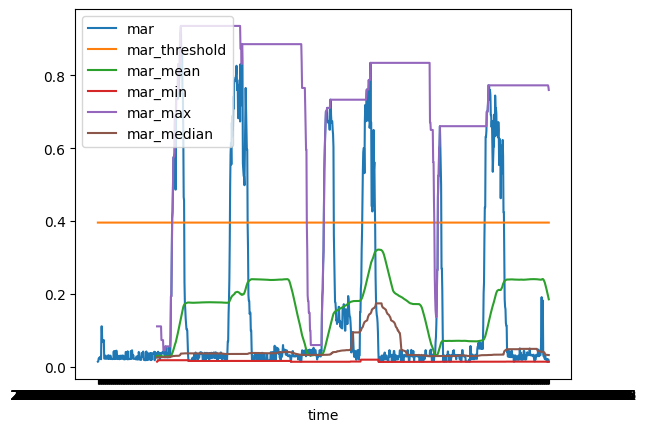

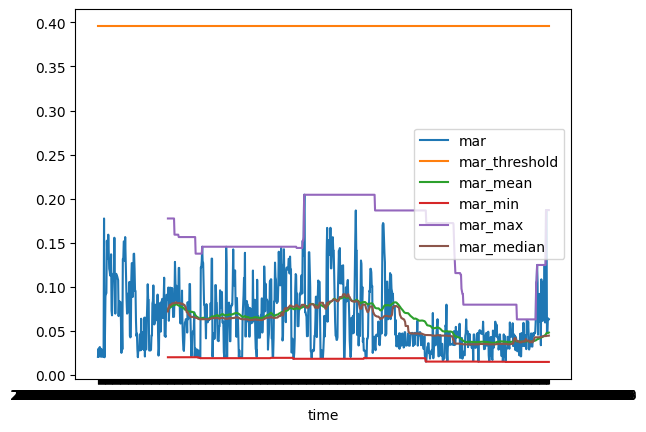

In [148]:
category = "durmiendome"
plot_mar(category)

category = "hablando"
plot_mar(category)